# dncnn

# Import Library

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import numpy as np
import os
from dncnn_model import dncnn_conv 
from tensorflow.keras import optimizers,metrics

tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
assert tf.__version__.startswith('2.')

# Define Constants

In [2]:
batch_size = 128
epochs = 10
image_width = 40
image_height = 40
sigma = 25

# Prepare Traning Data

### training data

In [3]:
def single_example_parser(example_proto):
    features = {"train400": tf.io.FixedLenFeature([], dtype=tf.string)}
    sequence_parsed = tf.io.parse_single_example(
        serialized=example_proto,
        features=features)
    return sequence_parsed

dataset = tf.data.TFRecordDataset('train400.tfrecords')

image_dataset = dataset.map(single_example_parser)
image_dataset = image_dataset.shuffle(1000)
image_dataset = image_dataset.batch(batch_size, drop_remainder=True)

### clean_pic

In [4]:
pic=next(iter(image_dataset))
pic = pic['train400']
pic = tf.io.decode_raw(pic, tf.uint8)
pic = tf.reshape(pic, [batch_size, image_width, image_height])
pic = pic / 255

# add noise
sigma=25
noise = tf.random.normal(pic.shape, 0, sigma / 255.0)
x_noise = pic + noise

# psnr
pic_psnr = tf.reshape(pic, [batch_size, image_width, image_height, 1])
x_noise_psnr = tf.reshape(x_noise, [batch_size, image_width, image_height, 1])

Text(0.5, 0, 'psnr:20.241583')

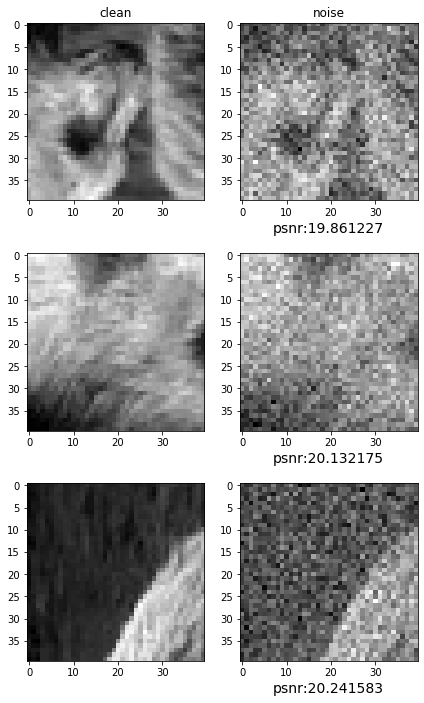

In [5]:
plt.figure(figsize=(7,12))#设定绘图窗口大小
plt.subplot(3,2,1)
plt.imshow(pic[0].numpy(),cmap='gray')
plt.title('clean')

plt.subplot(3,2,2)
plt.imshow(x_noise[0].numpy(),cmap='gray')
plt.xlabel('psnr:'+str(tf.image.psnr(x_noise_psnr[0], pic_psnr[0], 1.0).numpy()),fontsize=14)
plt.title('noise')

plt.subplot(3,2,3)
plt.imshow(pic[1].numpy(),cmap='gray')

plt.subplot(3,2,4)
plt.imshow(x_noise[1].numpy(),cmap='gray')
plt.xlabel('psnr:'+str(tf.image.psnr(x_noise_psnr[1], pic_psnr[1], 1.0).numpy()),fontsize=14)

plt.subplot(3,2,5)
plt.imshow(pic[2].numpy(),cmap='gray')

plt.subplot(3,2,6)
plt.imshow(x_noise[2].numpy(),cmap='gray')
plt.xlabel('psnr:'+str(tf.image.psnr(x_noise_psnr[2], pic_psnr[2], 1.0).numpy()),fontsize=14)

### test data
bsd68

In [6]:
def preprocess(x):
    # x: 图片的路径List，y：图片的数字编码List
    x = tf.io.read_file(x) # 根据路径读取图片
    x = tf.image.decode_jpeg(x, channels=1) # 图片解码
    x_clean = tf.cast(x, dtype=tf.float32) / 255.
    return x_clean
    

image_set68=tf.io.gfile.glob('data/Test/Set68'+'/*.png')
image_set68_db = tf.data.Dataset.from_tensor_slices((image_set68))
image_set68_db = image_set68_db.map(preprocess).batch(1)

# Build Model

In [7]:
model = dncnn_conv()
model.build(input_shape=(None, 40, 40, 1))
model.summary()
optimizer = optimizers.Adam(lr=1e-3)

Model: "dncnn_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c1 (Conv2D)                  multiple                  640       
_________________________________________________________________
a1 (Activation)              multiple                  0         
_________________________________________________________________
c2 (Conv2D)                  multiple                  36864     
_________________________________________________________________
b2 (BatchNormalization)      multiple                  256       
_________________________________________________________________
a2 (Activation)              multiple                  0         
_________________________________________________________________
c3 (Conv2D)                  multiple                  36864     
_________________________________________________________________
b3 (BatchNormalization)      multiple                  2

### training_function

In [8]:
@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
        out = model(x, training=True)
        loss = tf.reduce_sum(tf.losses.MSE(y, out))/2
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    loss_meter.update_state(loss)

In [9]:
acc_meter = metrics.Accuracy()
loss_meter = metrics.Mean()   

# Fit model

In [10]:
# for epoch in range(50):
#     for step, y_clean in enumerate(image_dataset):
#         y_clean = y_clean['train400']
#         y_clean = tf.io.decode_raw(y_clean, tf.uint8)
#         y_clean = tf.reshape(y_clean, [batch_size, image_width, image_height, 1])
#         y_clean = tf.cast(y_clean,dtype=tf.float32) / 255.0
#         noise = tf.random.normal(y_clean.shape, 0, sigma / 255.0)
#         x_noise = y_clean + noise
        
#         train_step(x_noise, y_clean)

#     psnr_all=[]
#     for step,x_clean in enumerate(image_set68_db):
#         noise = tf.random.normal(x_clean.shape, 0, sigma / 255.0)
#         x_noise=x_clean+noise
        
#         pred=model(x_noise,training=False)
#         psnr = tf.image.psnr(pred, x_clean, 1.0)
#         psnr_all.append(psnr)
#     psnr_mean=tf.reduce_mean(psnr_all)    

#     print('epoch:', epoch, 'loss:', loss_meter.result().numpy(), 'psnr:', psnr_mean.numpy())
#     #一次epoch保存一次模型   
#     sessFileName1 = 'model_weight/modelw%03d.hdf5' % (epoch + 1)
#     model.save_weights(sessFileName1)    

# Test

In [11]:
model.load_weights('model_weight/modelw011.hdf5')
test_iter=iter(image_set68_db)

Text(0.5, 1.0, 'pred')

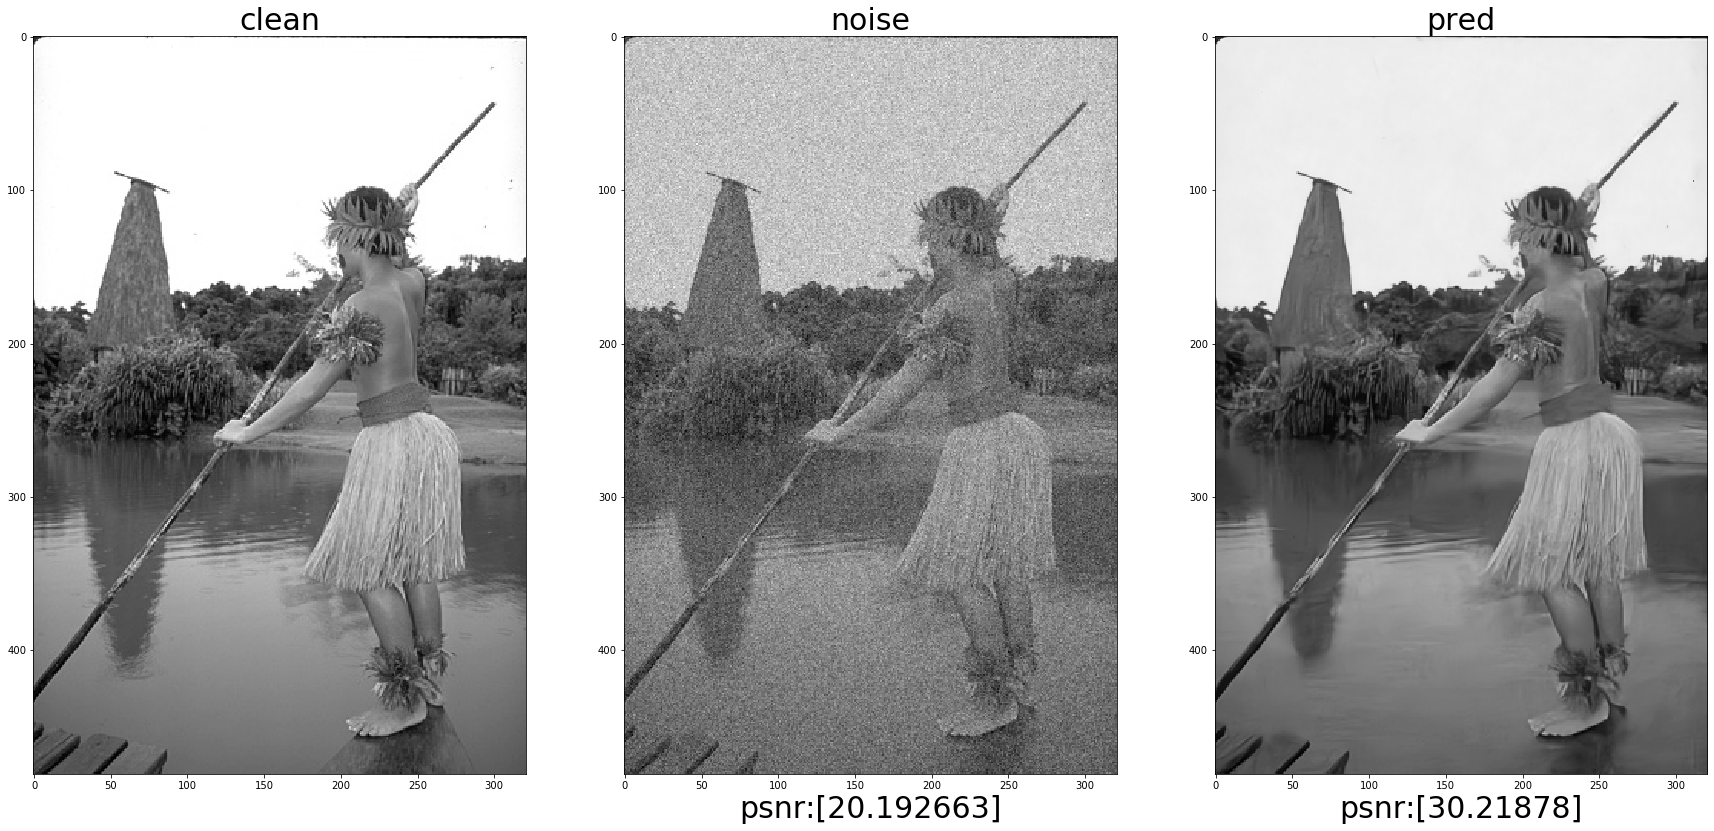

In [13]:
test_clean=next(test_iter)
test_noise = tf.random.normal(test_clean.shape, 0, sigma / 255.0)
test_x_noise=test_clean+test_noise
test_pred=model(test_x_noise,training=False)

plt.figure(figsize=(30,15))#设定绘图窗口大小
plt.subplot(1,3,1)
plt.imshow(tf.squeeze(test_clean).numpy(),cmap='gray')
plt.title('clean',fontsize=30)

plt.subplot(1,3,2)
plt.imshow(tf.squeeze(test_x_noise).numpy(),cmap='gray')
plt.xlabel('psnr:'+str(tf.image.psnr(test_clean, test_x_noise, 1.0).numpy()),fontsize=30)
plt.title('noise',fontsize=30)

plt.subplot(1,3,3)
plt.imshow(tf.squeeze(test_pred).numpy(),cmap='gray')
plt.xlabel('psnr:'+str(tf.image.psnr(test_clean, test_pred, 1.0).numpy()),fontsize=30)
plt.title('pred',fontsize=30)